In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection, jones_2009_model
from hnn_core.cells_default import _exp_g_at_dist, _linear_g_at_dist
from hnn_core.network_models import add_erp_drives_to_jones_model
from functools import partial
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

--No graphics will be displayed.


### Create base network with standard ERP drives and new NMDA synapses

In [13]:
l_contra_params = read_params('../data/L_Contra.param')
net_base = calcium_model(params=l_contra_params, add_drives_from_params=False)

# net_base = jones_2009_model()
# add_erp_drives_to_jones_model(net_base)

In [14]:
# Dendritic Km sweep
def L5_pyramidal_km_dend(net, scale=0.0):
    seed_rng = np.random.default_rng(123)
    seed_array = seed_rng.integers(0, 1e5, size=3)

    # Proximal 1 drive
    weights_ampa_p1 = {'L2_basket': 0.997291, 'L2_pyramidal':0.990722,'L5_basket':0.614932, 'L5_pyramidal': 0.004153}
    weights_nmda_p1 = {'L2_basket': 0.984337, 'L2_pyramidal':1.714247,'L5_basket':0.061868, 'L5_pyramidal': 0.010042}
    synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,'L5_basket': 1., 'L5_pyramidal': 1.}
    net.add_evoked_drive('evprox1', mu=54.897936, sigma=5.401034, numspikes=1, weights_ampa=weights_ampa_p1, weights_nmda=weights_nmda_p1, location='proximal',synaptic_delays=synaptic_delays_prox, event_seed=seed_array[0])
    # Distal drive
    weights_ampa_d1 = {'L2_basket': 0.624131, 'L2_pyramidal': 0.606619, 'L5_pyramidal':0.258}
    weights_nmda_d1 = {'L2_basket': 0.95291, 'L2_pyramidal': 0.242383, 'L5_pyramidal': 0.156725}
    synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1}
    net.add_evoked_drive('evdist1', mu=82.9915, sigma=13.208408, numspikes=1, weights_ampa=weights_ampa_d1,weights_nmda=weights_nmda_d1, location='distal',synaptic_delays=synaptic_delays_d1, event_seed=seed_array[1]) 
    # Second proximal evoked drive.
    weights_ampa_p2 = {'L2_basket': 0.758537, 'L2_pyramidal': 0.854454,'L5_basket': 0.979846, 'L5_pyramidal': 0.012483}
    weights_nmda_p2 = {'L2_basket': 0.851444, 'L2_pyramidal':0.067491 ,'L5_basket': 0.901834, 'L5_pyramidal': 0.003818}
    net.add_evoked_drive('evprox2', mu=161.306837, sigma=19.843986, numspikes=1, weights_ampa=weights_ampa_p2,weights_nmda= weights_nmda_p2, location='proximal',synaptic_delays=synaptic_delays_prox, event_seed=seed_array[2])
    

    for sec_name, sec in net.cell_types['L5_pyramidal']['cell_object'].sections.items():
        if sec_name != 'soma':
            sec.mechs['km']['gbar_km'] *= (10 ** scale)


# Inhibitory gain sweep
def inhibitory_gain(net, scale=0.0):
    """Modify all GABAb synapses"""
    seed_rng = np.random.default_rng(123)
    seed_array = seed_rng.integers(0, 1e5, size=3)

    # Proximal 1 drive
    weights_ampa_p1 = {'L2_basket': 0.997291, 'L2_pyramidal':0.990722,'L5_basket':0.614932, 'L5_pyramidal': 0.004153}
    weights_nmda_p1 = {'L2_basket': 0.984337, 'L2_pyramidal':1.714247,'L5_basket':0.061868, 'L5_pyramidal': 0.010042}
    synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,'L5_basket': 1., 'L5_pyramidal': 1.}
    net.add_evoked_drive('evprox1', mu=54.897936, sigma=5.401034, numspikes=1, weights_ampa=weights_ampa_p1, weights_nmda=weights_nmda_p1, location='proximal',synaptic_delays=synaptic_delays_prox, event_seed=seed_array[0])
    # Distal drive
    weights_ampa_d1 = {'L2_basket': 0.624131, 'L2_pyramidal': 0.606619, 'L5_pyramidal':0.258}
    weights_nmda_d1 = {'L2_basket': 0.95291, 'L2_pyramidal': 0.242383, 'L5_pyramidal': 0.156725}
    synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1}
    net.add_evoked_drive('evdist1', mu=82.9915, sigma=13.208408, numspikes=1, weights_ampa=weights_ampa_d1,weights_nmda=weights_nmda_d1, location='distal',synaptic_delays=synaptic_delays_d1, event_seed=seed_array[1]) 
    # Second proximal evoked drive.
    weights_ampa_p2 = {'L2_basket': 0.758537, 'L2_pyramidal': 0.854454,'L5_basket': 0.979846, 'L5_pyramidal': 0.012483}
    weights_nmda_p2 = {'L2_basket': 0.851444, 'L2_pyramidal':0.067491 ,'L5_basket': 0.901834, 'L5_pyramidal': 0.003818}
    net.add_evoked_drive('evprox2', mu=161.306837, sigma=19.843986, numspikes=1, weights_ampa=weights_ampa_p2,weights_nmda= weights_nmda_p2, location='proximal',synaptic_delays=synaptic_delays_prox, event_seed=seed_array[2])
    

    conn_indices = pick_connection(net, receptor=['gabab'])
    for conn_idx in conn_indices:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** scale

# Feedforward gain sweep
def feedforward_gain(net, scale=0.0):
    """Modify variance of first proximal input"""
    seed_rng = np.random.default_rng(123)
    seed_array = seed_rng.integers(0, 1e5, size=3)

    # Proximal 1 drive
    weights_ampa_p1 = {'L2_basket': 0.997291, 'L2_pyramidal':0.990722,'L5_basket':0.614932, 'L5_pyramidal': 0.004153}
    weights_nmda_p1 = {'L2_basket': 0.984337, 'L2_pyramidal':1.714247,'L5_basket':0.061868, 'L5_pyramidal': 0.010042}
    synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,'L5_basket': 1., 'L5_pyramidal': 1.}
    net.add_evoked_drive('evprox1', mu=54.897936, sigma=5.401034 * scale, numspikes=1, weights_ampa=weights_ampa_p1, weights_nmda=weights_nmda_p1, location='proximal',synaptic_delays=synaptic_delays_prox, event_seed=seed_array[0])
    # Distal drive
    weights_ampa_d1 = {'L2_basket': 0.624131, 'L2_pyramidal': 0.606619, 'L5_pyramidal':0.258}
    weights_nmda_d1 = {'L2_basket': 0.95291, 'L2_pyramidal': 0.242383, 'L5_pyramidal': 0.156725}
    synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1}
    net.add_evoked_drive('evdist1', mu=82.9915, sigma=13.208408, numspikes=1, weights_ampa=weights_ampa_d1,weights_nmda=weights_nmda_d1, location='distal',synaptic_delays=synaptic_delays_d1, event_seed=seed_array[1]) 
    # Second proximal evoked drive.
    weights_ampa_p2 = {'L2_basket': 0.758537, 'L2_pyramidal': 0.854454,'L5_basket': 0.979846, 'L5_pyramidal': 0.012483}
    weights_nmda_p2 = {'L2_basket': 0.851444, 'L2_pyramidal':0.067491 ,'L5_basket': 0.901834, 'L5_pyramidal': 0.003818}
    net.add_evoked_drive('evprox2', mu=161.306837, sigma=19.843986, numspikes=1, weights_ampa=weights_ampa_p2,weights_nmda= weights_nmda_p2, location='proximal',synaptic_delays=synaptic_delays_prox, event_seed=seed_array[2])
    
    # conn_indices = pick_connection(net, src_gids=['evprox1', 'evprox2'])
    # for conn_idx in conn_indices:
    #     net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** scale





def run_simulation(net_base, theta_i, prior_dict, return_net=False):
    assert len(theta_i) == len(prior_dict)

    net = net_base.copy()
    for param_idx, param_name in enumerate(prior_dict.keys()):
        update_function = prior_dict[param_name]['update_function']
        update_function(net, theta_i[param_idx])

    dpl = simulate_dipole(net, tstop=tstop, dt=dt, n_trials=1)
    dpl_data = dpl[0].copy().smooth(30).data['agg']

    if return_net:
        return (net, dpl_data)
    else:
        return dpl_data


In [15]:
min_val, max_val = 0, 1

prior_dict = {
    # 'L2e_L5i_nmda': {'bounds': (min_val, max_val), 'update_function': L2e_L5i_nmda, 'mech_name': 'L2e->L5i NMDA'},
    'feedforward_gain': {'bounds': (0, 2), 'update_function': feedforward_gain, 'mech_name': 'Feedforward gain'},
    'L5_pyramidal_km_dend': {'bounds': (min_val, max_val), 'update_function': L5_pyramidal_km_dend, 'mech_name': 'Dendritic Km'},
    'inhibitory_gain': {'bounds': (min_val, max_val), 'update_function': inhibitory_gain, 'mech_name': 'GABA disinhibition'},

}

num_params = len(prior_dict)
sweep_len = 10

theta = np.zeros((num_params * sweep_len, num_params))
labels = list()
for param_idx, param_name in enumerate(prior_dict.keys()):
    min_val, max_val = prior_dict[param_name]['bounds']
    sweep_values = np.linspace(min_val, max_val, sweep_len)

    start_idx = param_idx * sweep_len
    stop_idx = start_idx + sweep_len
    theta[start_idx:stop_idx, param_idx] = sweep_values

    labels.extend(np.repeat(prior_dict[param_name]['mech_name'], sweep_len).tolist())


In [16]:
tstop = 200
dt = 0.025

res = Parallel(n_jobs=50)(delayed(run_simulation)(net_base, theta[idx,:], prior_dict) for idx in range(theta.shape[0]))


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


ValueError: Drive evprox1 already defined

In [39]:
df_dict = {
    'dpl': res,
    'label': labels,
    'theta': theta.tolist()}
df = pd.DataFrame(df_dict)

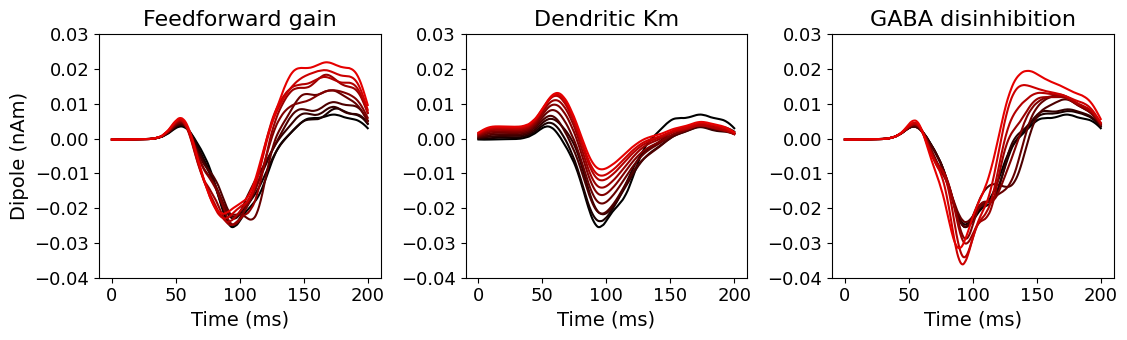

In [44]:
ticksize = 13
labelsize = 14
titlesize = 16

unique_labels = df['label'].unique()
times = np.linspace(0, tstop, len(res[0]))

plt.figure(figsize=(15,3.5))
for plot_idx, label_name in enumerate(unique_labels):

    cmap_color = 'r'
    colors = ['k', cmap_color] # first color is black, last is red
    cmap = LinearSegmentedColormap.from_list(
            "Custom", colors)

    plt.subplot(1, 4, plot_idx+1)
    mask = df['label'] == label_name
    dpl_data = df[mask]['dpl'].values

    for sim_idx in range(sweep_len):
        sweep_color = cmap(sim_idx / sweep_len)
        plt.plot(times, dpl_data[sim_idx], linewidth=1.5, color=sweep_color)

    plt.title(label_name, fontsize=titlesize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.xlabel('Time (ms)', fontsize=labelsize)

    plt.ylim(-0.04, 0.03)

plt.subplot(1,4,1)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)



plt.tight_layout()